In [29]:
import re
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import gseapy as gp



In [46]:
#BEFORE move forward please read this:
#SCIG-output file: Distance coloumn indicates the  "CIG_score" of each gene in given cell type
#to find the potential cell identity genes (CIGs) you can use either FDR or Pvalue with differrent cutoff (0.01,0.05). 
#The more Pvalue or FDR value will cover more CIGs candiates from SCIG output
##The following pipeline will be work for both output files (ends with "SCIG_CIGs_result.out","SCIG_MasterTFs_result.out" ) of SCIG.


In [ ]:
##Enter you working directory
path='/Users/h/Downloads/'
os.chdir(path)

##open SCIG output file
scig_ouput=pd.read_csv("Heart_muscle_hpa_pseudobulk.txt-hs-SCIG_CIGs_result.out",sep="\t")


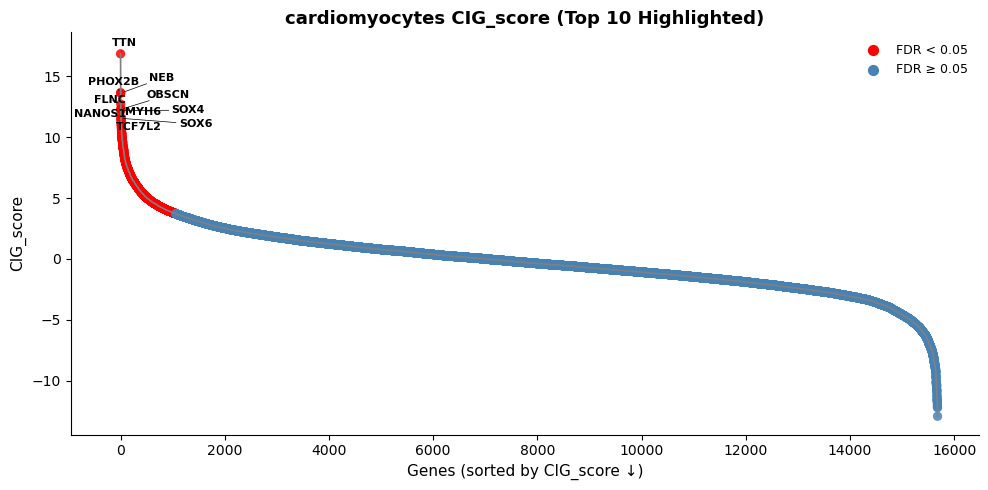

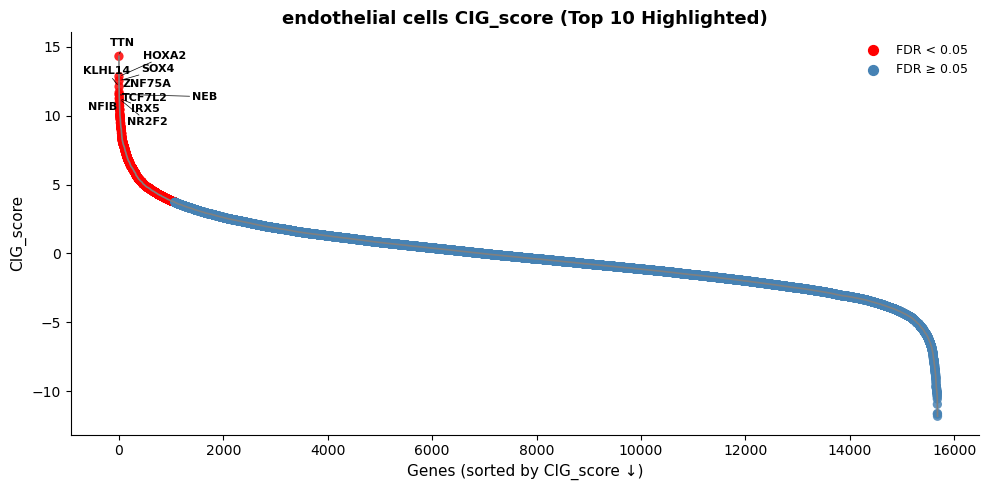

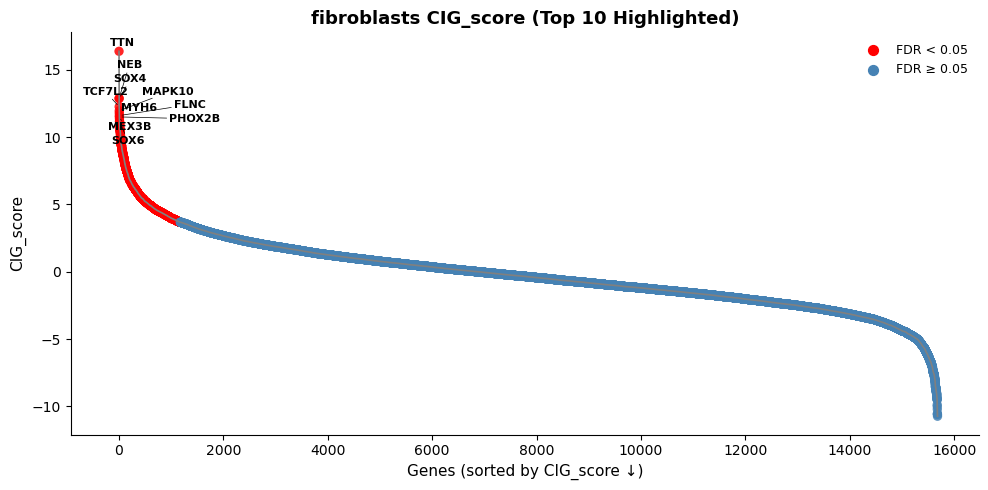

In [31]:
# --- Find all columns ending with '_distance' and '_FDR' ---
distance_cols = [c for c in scig_ouput.columns if c.endswith('_distance')]
fdr_cols = [c for c in scig_ouput.columns if c.endswith('_FDR')]

# --- Loop over each distance column ---
for dist_col in distance_cols:
    prefix = dist_col.replace('_distance', '')  # e.g., "LG1"
    fdr_col = f"{prefix}_FDR"

    # Skip if no matching FDR column
    if fdr_col not in scig_ouput.columns:
        print(f"⚠️ Skipping {dist_col} (no matching FDR column found)")
        continue

    # --- Sort by descending distance ---
    df_sorted = scig_ouput.sort_values(by=dist_col, ascending=False).reset_index(drop=True)

    # --- Define color by FDR significance ---
    df_sorted["color"] = df_sorted[fdr_col].apply(lambda x: 'red' if x < 0.05 else 'steelblue')

    # --- Get top 10 genes for labeling ---
    top10 = df_sorted.head(10)

    # --- Plot setup ---
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=df_sorted.index, y=df_sorted[dist_col], color='gray', linewidth=1.2)
    plt.scatter(df_sorted.index, df_sorted[dist_col],
                c=df_sorted["color"], s=45, edgecolor='none', alpha=0.85)

    # --- Label top 10 genes (non-overlapping) ---
    texts = []
    for i, row in top10.iterrows():
        texts.append(
            plt.text(i, row[dist_col], row['symbol'],
                     fontsize=8, ha='center', va='bottom', color='black', weight='bold')
        )
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

    # --- Add legend manually ---
    plt.scatter([], [], color='red', label='FDR < 0.05', s=50)
    plt.scatter([], [], color='steelblue', label='FDR ≥ 0.05', s=50)
    plt.legend(frameon=False, loc='upper right', fontsize=9)

    # --- Beautify (no gridlines, clean style) ---
    plt.title(f"{prefix} CIG_score (Top 10 Highlighted)", fontsize=13, weight='bold')
    plt.xlabel("Genes (sorted by CIG_score ↓)", fontsize=11)
    plt.ylabel("CIG_score", fontsize=11)
    plt.tight_layout()

    # Remove gridlines and spines for publication style
    plt.grid(False)
    sns.despine()

    # --- Optional: Save figure ---
    # plt.savefig(f"{prefix}_CIG_score_plot.png", dpi=300, bbox_inches='tight')

    plt.show()

Selected 1651 genes with FDR < 0.05 in at least one sample


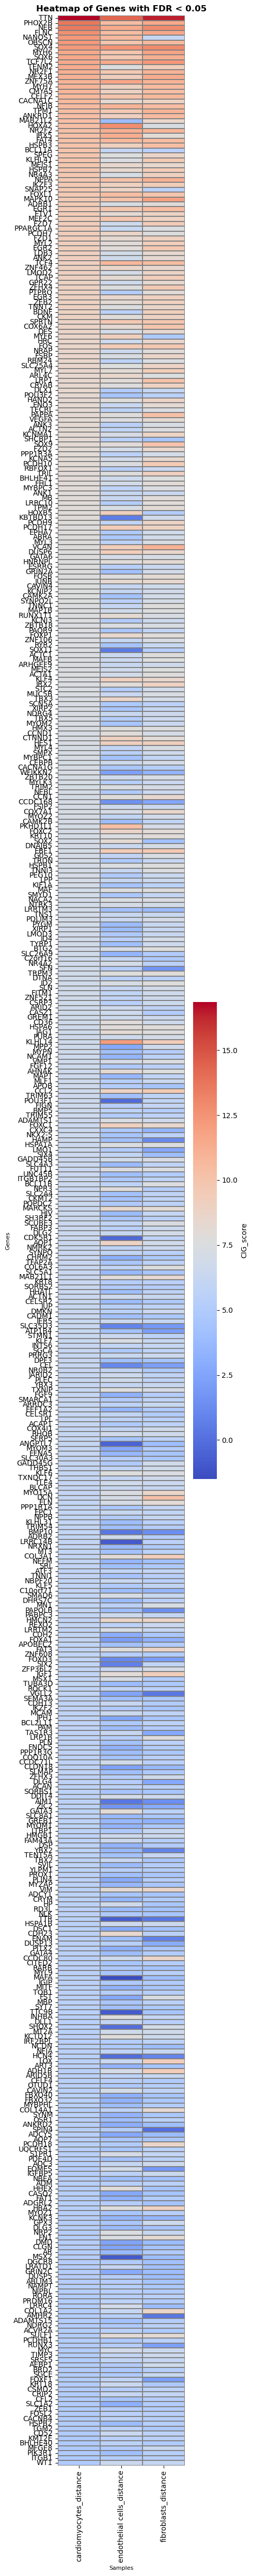

In [49]:
#heatmap for CIG genes and their score comparison across samples/celltypes

# Identify distance and FDR columns
distance_cols = [c for c in scig_ouput.columns if c.endswith('_distance')]
fdr_cols = [c for c in scig_ouput.columns if c.endswith('_FDR')]

# Filter genes: keep only those with FDR < 0.05 in at least one sample
mask_sig = (scig_ouput[fdr_cols] < 0.05).any(axis=1)
df_sig = scig_ouput[mask_sig].copy()

print(f"Selected {df_sig.shape[0]} genes with FDR < 0.05 in at least one sample")

# If too many genes, optionally limit to top 500 by minimum FDR
df_sig['min_FDR'] = df_sig[fdr_cols].min(axis=1)
#df_sig_top = df_sig.nsmallest(500, 'min_FDR')  # top 500 genes

# Prepare heatmap data
heatmap_data = df_sig_top.set_index('symbol')[distance_cols]

# Optional: normalize per column for better color comparison
# heatmap_data = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())

# Plot heatmap
plt.figure(figsize=(5, max(3, 0.1 * heatmap_data.shape[0])))  # dynamic height
sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={'label': 'CIG_score'},
    xticklabels=True,
    yticklabels=True
)
plt.title("Heatmap of Genes with FDR < 0.05", fontsize=12, weight='bold')
plt.xlabel("Samples", fontsize=8)
plt.ylabel("Genes", fontsize=8)
plt.tight_layout()
plt.show()


Index(['Geneid', 'cardiomyocytes_probability', 'cardiomyocytes_distance',
       'cardiomyocytes_p_value', 'cardiomyocytes_FDR', 'cardiomyocytes_rank',
       'endothelial cells_probability', 'endothelial cells_distance',
       'endothelial cells_p_value', 'endothelial cells_FDR',
       'endothelial cells_rank', 'fibroblasts_probability',
       'fibroblasts_distance', 'fibroblasts_p_value', 'fibroblasts_FDR',
       'fibroblasts_rank', 'cardiomyocytes_exp', 'endothelial cells_exp',
       'fibroblasts_exp'],
      dtype='object')


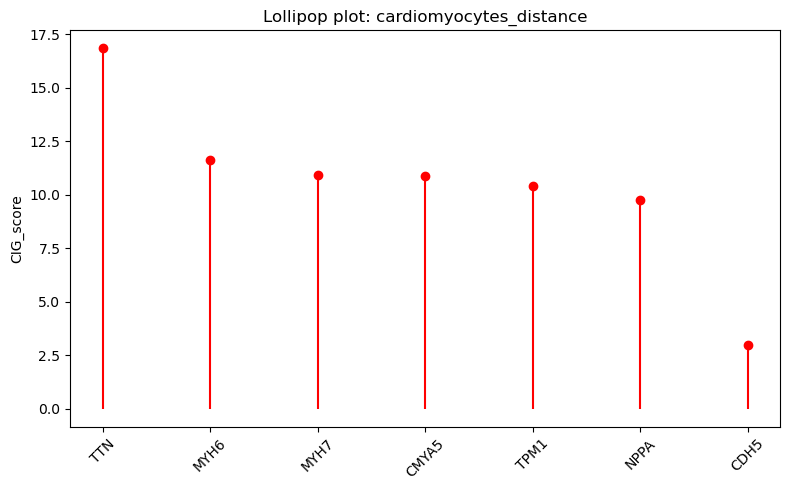

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: list of genes to plot
gene_list = ['TTN','MYH6', 'CDH5', 'MYH7', 'CMYA5','NPPA', 'TPM1']  # replace with your symbols

# Select your genes
df_lolli = scig_ouput[scig_ouput['symbol'].isin(gene_list)].set_index('symbol')
print(df_lolli.columns)
# Choose one column to plot, or loop over columns
col = 'cardiomyocytes_distance'###

# Sort values descending
df_lolli = df_lolli.sort_values(by=col, ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.stem(df_lolli.index, df_lolli[col], linefmt='red', markerfmt='o', basefmt=" ")
plt.xticks(rotation=45)
plt.ylabel('CIG_score')
plt.title(f'Lollipop plot: {col}')
plt.tight_layout()
plt.show()


In [66]:
fdr_cols

['cardiomyocytes_FDR', 'endothelial cells_FDR', 'fibroblasts_FDR']

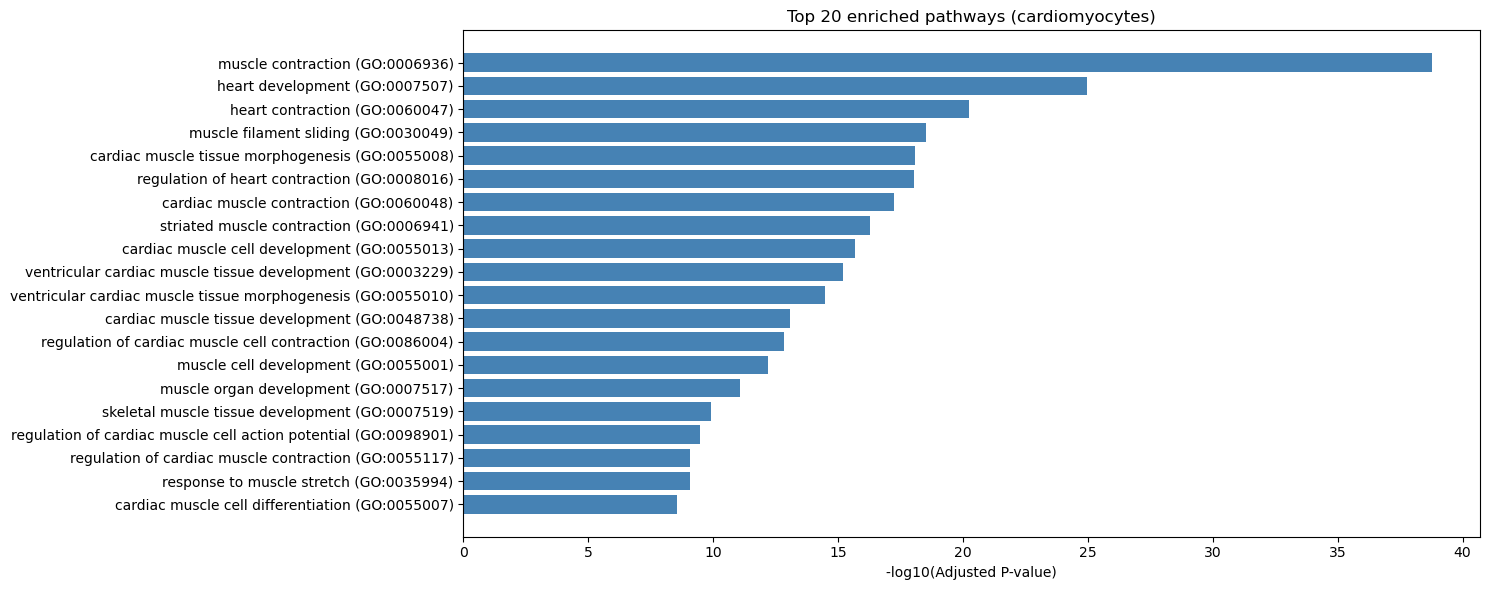

Plotted top pathways for cardiomyocytes


In [68]:
##pathway analysis
# -----------------------------
# GO enrichment and bar plot
# -----------------------------

#fdr_cols = [c for c in scig_ouput.columns if c.endswith('_FDR')]##automatcially get all the samples/cell types
fdr_cols=['cardiomyocytes_FDR']
symbol_col = 'symbol'

# Output directory
os.makedirs("pathway_results", exist_ok=True)

# Optional: keywords to filter GO terms
go_keywords = ['cardio','heart','muscle']

import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Loop over each sample (enrichment already done)
# ------------------------------
for fdr_col in fdr_cols:
    sample_name = fdr_col.replace('_FDR','')
    
    # Filter genes
    sig_genes = scig_ouput.loc[scig_ouput[fdr_col] < 0.05, symbol_col].unique()
    if len(sig_genes) == 0:
        continue
    
    # Run enrichment
    enr = gp.enrichr(
        gene_list=list(sig_genes),
        #gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021', 'Reactome_2022'],
        gene_sets=['GO_Biological_Process_2021'],

        organism='Human',
        outdir=f'pathway_results/{sample_name}',
        cutoff=0.05
    )
    
    pathways = enr.results.copy()
    
    # Optional: filter GO pathways by keywords
    mask = pathways['Term'].str.contains('|'.join(go_keywords), case=False, regex=True)
    pathways_filtered = pathways[mask]
    
    # Select top 20 pathways
    top_pathways = pathways_filtered.sort_values('Adjusted P-value').head(20)
    if top_pathways.empty:
        top_pathways = pathways.sort_values('Adjusted P-value').head(20)
    
    # Save CSV
    top_pathways.to_csv(f'pathway_results/{sample_name}_top_pathways.csv', index=False)
    
    # ------------------------------
    # Plot horizontal bar plot
    # ------------------------------
    plt.figure(figsize=(15, max(4, 0.3*len(top_pathways))))  # dynamic height
    plt.barh(
        top_pathways['Term'][::-1],
        -np.log10(top_pathways['Adjusted P-value'])[::-1],
        color='steelblue'
    )
    plt.xlabel('-log10(Adjusted P-value)')
    plt.title(f"Top 20 enriched pathways ({sample_name})")
    plt.tight_layout()
    plt.show()
    # Save figure
    #plt.savefig(f'pathway_results/{sample_name}_top_pathways_barplot.png', dpi=300)
    plt.close()
    
    print(f"Plotted top pathways for {sample_name}")
